In [1]:
import numpy as np
import networkx as nx
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt
from draw_network import draw_network
from scipy.stats import spearmanr

import pandas as pd

import warnings
warnings.filterwarnings('ignore', category = FutureWarning,)

import matplotlib
matplotlib.rc('xtick',labelsize=22)
matplotlib.rc('ytick',labelsize=22)
matplotlib.rc('font', size=12) 
matplotlib.rc('axes', labelsize=24)
matplotlib.rc('legend',fontsize = 17)
matplotlib.rc('figure',titlesize = 25)

In [2]:
def local_balance(G):   
    
    # calculate signed communicability
    A = nx.adjacency_matrix(G).todense()
    A0 = np.abs(A)
    
    Comm = la.expm(A)
    Comm0 = la.expm(A0)
    
    # calculate balance
    Ki = np.diag(Comm)/np.diag(Comm0)       # node balance
    
    # convert to dict
    Ki = {node: Ki[index] for index, node in enumerate(G.nodes())}
    
    return Ki



def PN_centrality(G):

    A = nx.adjacency_matrix(G).toarray()
    n = len(G.nodes())
    I = np.eye(n)
    P = np.maximum(A,np.zeros((n,n)))
    N = np.absolute(np.minimum(A,np.zeros((n,n))))
    Ap = P-2*N

    PN = np.linalg.inv(I-Ap/(2*n-2))@np.ones(n)

    # convert to dict 
    PN = {node: PN[index] for index, node in enumerate(G.nodes())}

    return PN



def PII_index(G, beta):

    k_max = np.max([d for n, d in G.degree()])
    d_max = nx.diameter(G)
    x = (np.log(2)-np.log(np.abs(beta)))/np.log(k_max)

    PII = {node: 0 for node in G.nodes()}

    for index, v in enumerate(G.nodes()):

        P_v = np.zeros(d_max+1)
        N_v = np.zeros(d_max+1)

        for w1, w2, s in G.edges(data = 'weight'):
            
            # find the shortest path length between node v and edge e
            d_vw1 = nx.shortest_path_length(G, source=v, target=w1)
            d_vw2 = nx.shortest_path_length(G, source=v, target=w2)
            d_ve = np.min([d_vw1, d_vw2])

            # add +1 to the number of positive or negative edges at distance d_ve
            if s > 0:
                P_v[d_ve] += 1
            else:
                N_v[d_ve] += 1

            
        # compute the PII formula
        for i in range(d_max):
            PII[v] += beta**i *(P_v[i]**x - N_v[i]**x)

    return PII



def triangle_index(G):

    A = nx.adjacency_matrix(G).todense()
    Acube = np.linalg.matrix_power(A, 3)
    absAcube = np.linalg.matrix_power(np.abs(A), 3)
    triag_idx = np.diag(Acube + absAcube)/2/np.diag(absAcube)

    # convert to dict
    triag_idx = {node: triag_idx[index] for index, node in enumerate(G.nodes())}

    return triag_idx

       

def eigenvector_centrality(G):

    # diagonalize matrix
    Lamb, U = la.eig(nx.adjacency_matrix(G).todense())

    # return eigenvector corresponding to the largest eigenvalue
    idx = np.argmax(Lamb)
    EVec = U[:,idx]

    #store in a dict
    EVec = {node: EVec[index] for index, node in enumerate(G.nodes())}
    return EVec

# Compare centralities in synthetic networks

### Balanced graph

/tmp/ipykernel_3375198/1954102836.py:78: RuntimeWarning: invalid value encountered in divide
  triag_idx = np.diag(Acube + absAcube)/2/np.diag(absAcube)


,PN_centrality,PII_index,Kloc,tr_index
3,1.219512,0.156535,1.0,1.0
1,1.219512,0.156535,1.0,1.0
5,1.317073,1.156535,1.0,NaN
4,1.317073,1.156535,1.0,NaN
2,0.390244,-3.782675,1.0,1.0


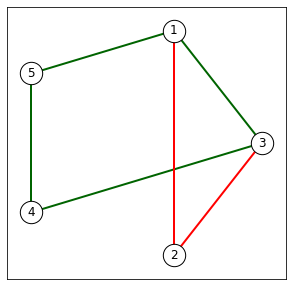

In [3]:
G = nx.cycle_graph(4)
for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

G.add_edges_from([(0,5,{'weight': -1}), (1,5,{'weight': -1})])

G = nx.relabel_nodes(G, {0:3, 1:1, 2:5, 3:4, 5:2})

fig, ax = plt.subplots(figsize = (5, 5))
pos = nx.circular_layout(G)
draw_network(G, pos = pos, ax = ax)

PN_centr = PN_centrality(G)
PII_idx = PII_index(G,beta = -0.8)
Kloc = local_balance(G)
triangle_idx = triangle_index(G)

df = pd.DataFrame({'PN_centrality': PN_centr, 'PII_index': PII_idx, 'Kloc': Kloc, 'tr_index': triangle_idx})
df.head(10)

### Unbalanced graph

/tmp/ipykernel_3375198/1954102836.py:78: RuntimeWarning: invalid value encountered in divide
  triag_idx = np.diag(Acube + absAcube)/2/np.diag(absAcube)


,PN_centrality,PII_index,Kloc,tr_index
3,1.128330,0.156535,0.928604,1.0
1,0.626884,-2.782675,0.928604,1.0
5,1.240371,2.408815,0.896023,NaN
4,1.296088,1.156535,0.896023,NaN
2,0.984320,-0.626140,0.980647,1.0


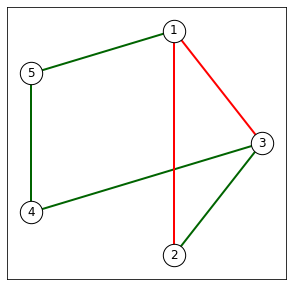

In [4]:
G = nx.cycle_graph(4)
for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

G.add_edges_from([(0,5,{'weight': 1}), (1,5,{'weight': -1})])
G[1][0]['weight'] = -1

G = nx.relabel_nodes(G, {0:3, 1:1, 2:5, 3:4, 5:2})

fig, ax = plt.subplots(figsize = (5, 5))
pos = nx.circular_layout(G)
draw_network(G, pos = pos, ax = ax)

PN_centr = PN_centrality(G)
PII_idx = PII_index(G,beta = -0.8)
Kloc = local_balance(G)
triangle_idx = triangle_index(G)

df = pd.DataFrame({'PN_centrality': PN_centr, 'PII_index': PII_idx, 'Kloc': Kloc, 'tr_index': triangle_idx})
df.head(10)

# Empirical networks: Gahuku-Gama

In [5]:
# Highland tribes
# read txt containing adjacency matirx
P = np.loadtxt('tribes_dataset/Highland_tribes_adjacency_pos.txt')
N = np.loadtxt('tribes_dataset/Highland_tribes_adjacency_neg.txt')
A = P-N

node_names = np.loadtxt('tribes_dataset/Highland_tribes_names.txt', dtype = str)
names_dict = {i:node_names[i] for i in range(len(node_names))}

# create networkx graph
G = nx.from_numpy_array(A)
nx.relabel_nodes(G, names_dict, copy=False)


# compute centrality indices
EVec = eigenvector_centrality(G)
PN_centr = PN_centrality(G)
PII_idx = PII_index(G,beta = -0.8)
Kloc = local_balance(G)
triangle_idx = triangle_index(G)


df = pd.DataFrame({'Eigenvector': EVec, 'PN_centrality': PN_centr, 'PII_index': PII_idx, 'Kloc': Kloc, 'triangle_index': triangle_idx})




print(df.sort_values(by = 'Kloc', ascending = False))

       Eigenvector  PN_centrality  PII_index      Kloc  triangle_index
ALIKA    -0.128459       1.022604  -0.410729  0.719149        1.000000
OVE      -0.249842       1.041977  -0.317311  0.585953        1.000000
GAVEV     0.348895       0.752661   0.112111  0.535242        1.000000
UKUDZ    -0.234110       1.141460   1.347074  0.476757        1.000000
KOTUN     0.310096       0.764224   0.411052  0.434599        0.933333
NAGAM    -0.259240       0.902669   0.870040  0.428654        1.000000
ASARO    -0.318726       0.934095   0.154844  0.417206        0.933333
MASIL    -0.265222       1.223561   2.687568  0.395421        0.800000
GAMA      0.344446       0.714519   0.964608  0.368477        0.850000
NAGAD     0.318171       0.714686   0.542331  0.360089        0.850000
GAHUK    -0.333037       0.905457  -0.252128  0.341833        0.863636
KOHIK    -0.083351       0.903383   0.066769  0.260303        0.875000
GEHAM    -0.242969       0.865317  -0.539700  0.255924        0.750000
NOTOH 

In [6]:
# spearman correlation matrix

corr = np.zeros((5,5))
for i, centr1 in enumerate(['Eigenvector', 'PII_index', 'PN_centrality','triangle_index','Kloc']):
    for j, centr2 in enumerate(['Eigenvector', 'PII_index', 'PN_centrality','triangle_index','Kloc']):
        corr[i,j] = spearmanr(df[centr1], df[centr2])[0]

print(np.round(corr,4))

[[ 1.      0.0471 -0.7324 -0.1167 -0.0912]
 [ 0.0471  1.      0.      0.2214  0.2794]
 [-0.7324  0.      1.      0.208   0.2618]
 [-0.1167  0.2214  0.208   1.      0.8932]
 [-0.0912  0.2794  0.2618  0.8932  1.    ]]
